<font color='blue'> **______________________________________________** </font> 

In [1]:
import pathlib as pl ; import flopy   ; import matplotlib.pyplot as plt ; import numpy as np ; from flopy.discretization import StructuredGrid ; from typing import List, Tuple, Union ; 
from pathlib import Path ; import pickle ; import pandas as pd ; from flopy.utils.gridintersect import GridIntersect  ; from shapely.geometry import LineString, Polygon 
import warnings ; warnings.filterwarnings("ignore", category=DeprecationWarning)  ; Lx=180000 ;Ly=100000     ;dx=dy=2500.0        ; nrow=int(Ly/dy)+1 ;ncol=int(Lx/dx)+1  
REF1 = Path('E:/15_REPOS/02_Beta-Me/data/GW3099-2024')                            ; TA = Path("./TA") ;TA.mkdir(exist_ok=True)    ; R2 = REF1/"fine_topo.tif"; TOPO = flopy.utils.Raster.load(R2)
with open(REF1/ "Geometry", 'rb') as handle:  GEO = pickle.load(handle)           ; from flopy.plot import styles
pd.DataFrame(GEO,index=[50]).to_csv(TA/'dict.csv')                                ; GEO["boundary"] #; pd.DataFrame(GEO,index=[50]) 

'1.868012422360248456e+05 4.695652173913043953e+04\n1.790372670807453396e+05 5.204968944099379587e+04\n1.729813664596273447e+05 5.590062111801243009e+04\n1.672360248447204940e+05 5.987577639751553215e+04\n1.631987577639751253e+05 6.335403726708075556e+04\n1.563664596273291972e+05 6.819875776397516893e+04\n1.509316770186335489e+05 7.229813664596274612e+04\n1.453416149068323139e+05 7.527950310559007630e+04\n1.395962732919254631e+05 7.627329192546584818e+04\n1.357142857142857101e+05 7.664596273291927355e+04\n1.329192546583850926e+05 7.751552795031057030e+04\n1.268633540372670832e+05 8.062111801242237561e+04\n1.218944099378881947e+05 8.285714285714286962e+04\n1.145962732919254486e+05 8.571428571428572468e+04\n1.069875776397515583e+05 8.869565217391305487e+04\n1.023291925465838431e+05 8.931677018633540138e+04\n9.456521739130433707e+04 9.068322981366459862e+04\n8.804347826086955320e+04 9.080745341614908830e+04\n7.950310559006211406e+04 9.267080745341615693e+04\n7.562111801242236106e+04 9.391

In [2]:
def string2geom(geostring: str,conversion: float = None,) -> List[tuple]:
    if conversion is None:     multiplier = 1.0 
    else:                      multiplier = float(conversion)   
    res = []
    for line in geostring.split("\n"):  line = line.split(" ")   ;x=float(line[0])*multiplier ;y=float(line[1])*multiplier    ; res.append((x, y))
    return res

LIST1   = string2geom(GEO["boundary"])  ; print(LIST1) ;CCA=np.array(LIST1)        ; AA=(GEO["streamseg1"] ,GEO["streamseg2"] ,GEO["streamseg3"] ,GEO["streamseg4"])  
LIST2=[string2geom(aa) for aa in AA]    ; #print('boundary:',LIST2[1])             ; pd.DataFrame(LIST2[len(LIST2)-1]).to_csv(TA/'SRT04.csv')

[(186801.24223602485, 46956.52173913044), (179037.26708074534, 52049.689440993796), (172981.36645962734, 55900.62111801243), (167236.0248447205, 59875.77639751553), (163198.75776397513, 63354.037267080756), (156366.4596273292, 68198.75776397517), (150931.67701863355, 72298.13664596275), (145341.6149068323, 75279.50310559008), (139596.27329192546, 76273.29192546585), (135714.2857142857, 76645.96273291927), (132919.2546583851, 77515.52795031057), (126863.35403726708, 80621.11801242238), (121894.4099378882, 82857.14285714287), (114596.27329192545, 85714.28571428572), (106987.57763975156, 88695.65217391305), (102329.19254658384, 89316.7701863354), (94565.21739130434, 90683.2298136646), (88043.47826086955, 90807.45341614909), (79503.10559006211, 92670.80745341616), (75621.11801242236, 93913.04347826088), (66925.4658385093, 96024.8447204969), (56677.01863354038, 97639.75155279505), (49068.322981366466, 96894.40993788821), (38975.155279503095, 95403.72670807455), (31677.018633540363, 93043.47

In [3]:
def STRUCT(modelgrid: flopy.discretization.StructuredGrid  ,boundary: List[tuple]) -> None:             # set_structured_idomain
    global RES, IDO
    IX = GridIntersect(modelgrid,method="vertex",rtree=True)   ; RES=IX.intersect(Polygon(boundary))  ;idx=[coords for coords in RES.cellids] ;idx=np.array(idx,dtype=int) ; NR=idx.shape[0]
    if idx.ndim == 1:  idx = idx.reshape((NR, 1))
    idx = tuple([idx[:, i] for i in range(idx.shape[1])])      ; IDO=np.zeros(modelgrid.shape[1:], dtype=int)    ; IDO[idx]=1 ;IDO=IDO.reshape(modelgrid.shape)
    modelgrid.idomain = IDO         ; return

GRID=StructuredGrid(nlay=1 ,delr=np.full(ncol, dx),delc=np.full(nrow,dy) ,xoff=0.0,yoff=0.0,top=np.full((nrow, ncol),1000.0),botm=np.full((1,nrow,ncol),-100.0))  ;STRUCT(GRID,LIST1) ; GRID


xll:0.0; yll:0.0; rotation:0.0; units:undefined; lenuni:0

In [4]:
pd.DataFrame(IDO[0,:,:]).to_csv(TA/'2D_grid.csv')                                          ; TT=TOPO.resample_to_grid(GRID,band=TOPO.bands[0],method="linear",extrapolate_edges=True);IDO
def intersect_segments(modelgrid:   Union[flopy.discretization.StructuredGrid,flopy.discretization.VertexGrid],segments:List[List[tuple]]) -> Tuple[flopy.utils.GridIntersect,list,list]:
    ixs = flopy.utils.GridIntersect(modelgrid,method=modelgrid.grid_type)  ; cellids = []         ; lengths = []
    for sg in segments:                    v = ixs.intersect(LineString(sg), sort_by_cellid=True) ; cellids += v["cellids"].tolist()  ; lengths += v["lengths"].tolist()
    return ixs, cellids, lengths
ixs, cellids, lengths = intersect_segments(GRID, LIST2)                                           ; INTER = np.zeros(GRID.shape[1:])      
for loc in cellids:     INTER[loc] = 1
RIV = GRID.idomain[0].copy() ; index = tuple(np.array(list(zip(*cellids))))                       ; RIV [index]=2  ;GRID.idomain=RIV.reshape(1, nrow, ncol)

<font color='Orange'> **DRN ______________________________________________________________________________** </font> 

In [5]:
def Drain_data(modelgrid:           Union[flopy.discretization.StructuredGrid,flopy.discretization.VertexGrid],cellids:list,lengths:list,leakance:float,elevation:np.ndarray,) -> List[tuple]:
    global DRN; DRN = []
    for cellid, length in zip(cellids, lengths):
        x = modelgrid.xcellcenters[cellid]    ; width = 5.0+(14.0/Lx)*(Lx-x)  ; COND = leakance*length*width
        if not isinstance(cellid, tuple):      cellid = (cellid,)
        DRN.append((0, *cellid, elevation[cellid], COND))
    return DRN
dv0 = 5.0  ; leakance = 1.0 / (0.5 * dv0)     ; DRN = Drain_data(GRID,cellids,lengths,leakance,TT)  ; Drn = pd.DataFrame(DRN) ;Drn.to_csv(TA/'DRN.csv') ; Drn.tail(2)

,0,1,2,3,4
167,0,10,33,57.362123,1878.569073
168,0,9,33,55.769709,12026.353414


<font color='Orange'> **DISC ______________________________________________________________________________** </font> 

In [6]:
def Cell_areas(modelgrid:           Union[flopy.discretization.StructuredGrid, flopy.discretization.VertexGrid]) -> np.ndarray:
    if modelgrid.grid_type == "structured": 
        nrow, ncol = modelgrid.nrow, modelgrid.ncol    ; areas = np.zeros((nrow, ncol), dtype=float)
        for r in range(nrow):
            for c in range(ncol):                       cellid = (r, c) ; vertices = np.array(modelgrid.get_cell_vertices(cellid)) ; area = Polygon(vertices).area ; areas[cellid] = area
    elif modelgrid.grid_type == "vertex":   
        areas = np.zeros(modelgrid.ncpl, dtype=float)
        for idx in range(modelgrid.ncpl):               vertices = np.array(modelgrid.get_cell_vertices(idx))  ; area = Polygon(vertices).area      ; areas[idx] = area
    else:   raise ValueError(+ f"{modelgrid.grid_type}")
    return areas

def GW_discharge_data(modelgrid:    Union[flopy.discretization.StructuredGrid, flopy.discretization.VertexGrid]  ,leakance: float  ,elevation: np.ndarray,) -> List[tuple]:
    areas = Cell_areas(modelgrid)   ; DRN = [] ; IDO = modelgrid.idomain[0]
    for idx in range(modelgrid.ncpl):
        if modelgrid.grid_type == "structured":  r, c = modelgrid.get_lrc(idx)[0][1:]  ; cellid = (r, c)
        else:                                    cellid = idx  
        area = areas[cellid]
        if IDO[cellid] == 1:    
            COND = leakance * area   
            if not isinstance(cellid, tuple):    cellid = (cellid,)
            DRN.append((0, *cellid, elevation[cellid] - 0.5, COND, 1.0))
    return DRN
DIS = GW_discharge_data(GRID,leakance,TT)  ; Dis = pd.DataFrame(DIS) ;Dis.to_csv(TA/'DIS.csv') ; Dis.tail(2)

,0,1,2,3,4,5
1917,0,39,52,71.164299,2500000.0,1.0
1918,0,39,53,71.010269,2500000.0,1.0


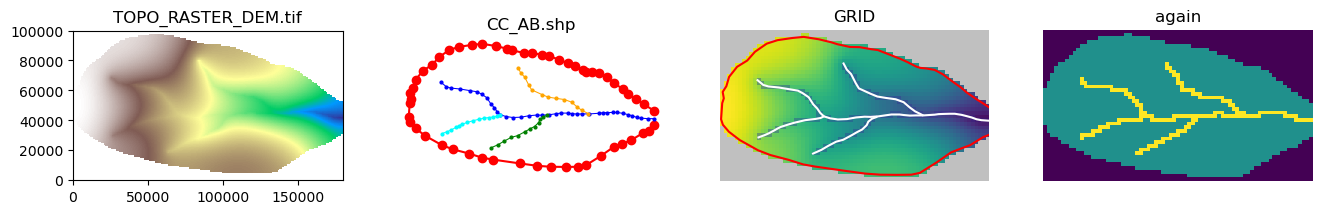

In [7]:
fig = plt.figure(figsize=(16,3))                                                         
ax = fig.add_subplot(141)       ; TOPO.plot(ax=ax, cmap="terrain")                                        ; plt.title("TOPO_RASTER_DEM.tif")   
ax = fig.add_subplot(142)       ; ax.set_aspect("equal")     ; COL=("blue","cyan","green","orange")       ; ax.plot(CCA[:,0],CCA[:,1], "ro-")  

for idx, SG in enumerate(LIST2) : CCB = np.array(SG)         ; plt.title("CC_AB.shp") ;plt.axis('off')    ; ax.plot(CCB[:,0],CCB[:,1], color=COL[idx],lw=0.75, marker="o", markersize=2) 

ax = fig.add_subplot(143)       ; PM=flopy.plot.PlotMapView(modelgrid=GRID) ; ax.set_aspect("equal")  ; PM.plot_array(TT)
n='n'                           ; PM.plot_array(INTER,masked_values=[0,],alpha=0.2,cmap="terrain")    ; PM.plot_inactive(color_noflow="silver")  ; ax.plot(CCA[:,0],CCA[:,1],"red")   
for LI in LIST2                 : ST = np.array(LI)  ; ax.plot(ST[:, 0], ST[:, 1], "white")                            ; plt.axis('off') ; plt.title("GRID")

ax = fig.add_subplot(144)       ; plt.imshow(GRID.idomain[0])                                                          ; plt.axis('off') ; plt.title("again") ; plt.show(block=False)     

In [8]:
nlay=5 ;IDO=np.array([GRID.idomain[0,:,:].copy() for k in range(nlay)])  ; IC=np.array([TT.copy() for k in range(nlay)] ,dtype=float)  ;TOPC=np.zeros((nlay, nrow, ncol)  ,dtype=float)
BOTM = np.zeros((nlay, nrow, ncol), dtype=float)                         ; dv=dv0 ; TOPC[0] = TT.copy()                 ; BOTM[0]   = TOPC[0]   - dv    ; print('dv0_DRN_______:', dv0)
for idx in range(1, nlay):  dv *= 1.5       ; TOPC[idx]=BOTM[idx-1]      ; BOTM[idx] = TOPC[idx] - dv                   ; #for k in range(nlay): print((TOPC[k]-BOTM[k]).mean())

dv0_DRN_______: 5.0


In [9]:
sim = flopy.mf6.MFSimulation(sim_ws=TA,exe_name="mf6",memory_print_option="summary",)                                        ; flopy.mf6.ModflowTdis   (sim)
flopy.mf6.ModflowIms        (sim,complexity="simple",print_option="SUMMARY",csv_outer_output_filerecord="outer.csv",csv_inner_output_filerecord="inner.csv",linear_acceleration="bicgstab"
                                ,outer_maximum=1000,inner_maximum=100,outer_dvclose=1e-4,inner_dvclose=1e-5,preconditioner_levels=2,relaxation_factor=0.0)
gwf = flopy.mf6.ModflowGwf  (sim,print_input=True,save_flows=True,newtonoptions="NEWTON UNDER_RELAXATION")
flopy.mf6.ModflowGwfdis  (gwf   ,nlay=nlay,nrow=nrow,ncol=ncol,delr=dx,delc=dy,idomain=IDO,top=TT,botm=BOTM,xorigin=0.0,yorigin=0.0)       ; flopy.mf6.ModflowGwfic   (gwf, strt=IC)
flopy.mf6.ModflowGwfnpf  (gwf   ,save_specific_discharge=True,icelltype=1,k=1.0)                                                           ; flopy.mf6.ModflowGwfrcha (gwf, recharge=0.000001)
flopy.mf6.ModflowGwfdrn  (gwf                                                    ,maxbound=len(DRN) ,stress_period_data=DRN ,pname="DRN1"  ,filename="drn_riv.drn")    # _______ DRN _______ 
flopy.mf6.ModflowGwfdrn  (gwf   ,auxiliary=["depth"] ,auxdepthname="depth"       ,maxbound=len(DIS) ,stress_period_data=DIS ,pname="DRN2"  ,filename="drn_gwd.drn")    # __EVERWHERELSE__0 Layer
flopy.mf6.ModflowGwfoc   (gwf   ,head_filerecord=f"{gwf.name}.hds",budget_filerecord=f"{gwf.name}.cbc",saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],printrecord=[("BUDGET", "ALL")]) ; 

sim.write_simulation(silent=False)                                               ; success, buff = sim.run_simulation(silent=True)                                ; assert success

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model model...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package drn1...
    writing package drn2...
    writing package oc...


In [10]:
WT = flopy.utils.postprocessing.get_water_table(gwf.output.head().get_data())   ; H0=gwf.output.head().get_data()      ; hmin,hmax=WT.min(), WT.max() ; CONT=np.arange(0, 100, 10)

Hmin: 1 Hmax: 91


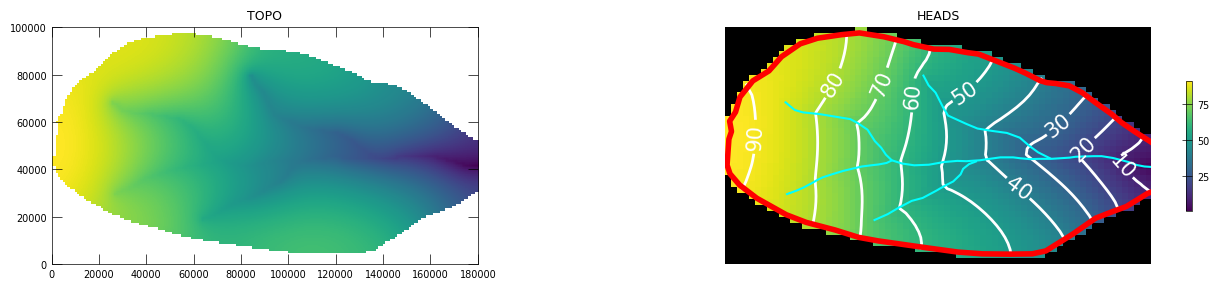

A: 102500 182500     DIS_max: 41 73
B: 37500 50000
C: 75000 175000


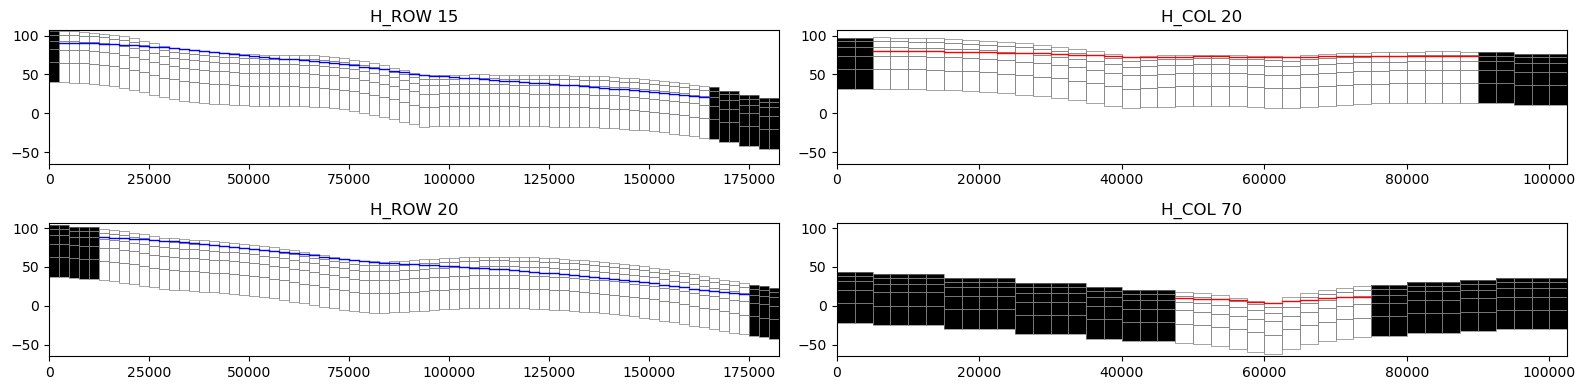

In [11]:
with styles.USGSMap():
    fig = plt.figure(figsize=(14, 3))
    ax = fig.add_subplot(121)  ; TOPO.plot(ax=ax)       ; plt.title("TOPO")    #; plt.axis('off') 
    ax = fig.add_subplot(122)  ; ax.set_xlim(0, Lx)     ; ax.set_ylim(0, Ly)   ; ax.set_aspect("equal")  ; pmv = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid, ax=ax)  ;pmv.plot_inactive() 
    HH = pmv.plot_array(H0, vmin=hmin, vmax=hmax) ; CC = pmv.contour_array(WT,levels=CONT,colors="white" ,linewidths=2,linestyles="-",)   ; plt.clabel(CC, fontsize=15)  ;plt.axis('off') 
    plt.colorbar(HH, ax=ax, shrink=0.55)             ; ax.plot(CCA[:,0], CCA[:,1], "red",linewidth=4)      ; plt.title("HEADS")             ; print('Hmin:',int(hmin), 'Hmax:',int(hmax))
    for SG in LIST2:  CCB = np.array(SG)              ; ax.plot(CCB[:,0], CCB[:,1], "cyan")                  
plt.tight_layout()             ; plt.show(block=False)          # just DRN(XY)

print('A:', int(nrow * dx), int(ncol * dy),'    DIS_max:',nrow, ncol)                     ;print('B:',int(15*dx),int(20*dy));print('C:',int(30*dx),int(70*dy))
fig = plt.figure(figsize=(16, 4))
ax=fig.add_subplot(221);W=flopy.plot.PlotCrossSection(model=gwf,ax=ax,line={"row":   15}) ;W.plot_inactive();plt.title("H_ROW 15")   ;W.plot_grid(linewidth=0.5) ;W.plot_surface(WT,color="b",lw=1)  
ax=fig.add_subplot(222);W=flopy.plot.PlotCrossSection(model=gwf,ax=ax,line={"column":20}) ;W.plot_inactive();plt.title("H_COL 20")   ;W.plot_grid(linewidth=0.5) ;W.plot_surface(WT,color="r",lw=1)  
ax=fig.add_subplot(223);W=flopy.plot.PlotCrossSection(model=gwf,ax=ax,line={"row":   30}) ;W.plot_inactive();plt.title("H_ROW 20")   ;W.plot_grid(linewidth=0.5) ;W.plot_surface(WT,color="b",lw=1)  
ax=fig.add_subplot(224);W=flopy.plot.PlotCrossSection(model=gwf,ax=ax,line={"column":70}) ;W.plot_inactive();plt.title("H_COL 70")   ;W.plot_grid(linewidth=0.5) ;W.plot_surface(WT,color="r",lw=1)  
plt.tight_layout() ; plt.show(block=False) 

In [12]:
geometry = {                                                "boundary"  : """1.868012422360248456e+05 4.695652173913043953e+04 
1.868012422360248456e+05 3.577639751552795497e+04""",       "streamseg1": """1.868012422360248456e+05 4.086956521739130403e+04
2.546583850931676716e+04 6.832298136645962950e+04""",       "streamseg2": """7.025161490683228476e+04 4.375093167701864149e+04
2.608695652173913550e+04 2.957521739130435890e+04""",       "streamseg3": """1.059006211180124228e+05 4.335403726708074828e+04
6.304347826086958230e+04 1.863354037267081003e+04""",       "streamseg4": """1.371118012422360480e+05 4.472049689440994553e+04
8.369565217391305487e+04 7.962732919254660374e+04""",}      ; geometry

{'boundary': '1.868012422360248456e+05 4.695652173913043953e+04 \n1.868012422360248456e+05 3.577639751552795497e+04',
 'streamseg1': '1.868012422360248456e+05 4.086956521739130403e+04\n2.546583850931676716e+04 6.832298136645962950e+04',
 'streamseg2': '7.025161490683228476e+04 4.375093167701864149e+04\n2.608695652173913550e+04 2.957521739130435890e+04',
 'streamseg3': '1.059006211180124228e+05 4.335403726708074828e+04\n6.304347826086958230e+04 1.863354037267081003e+04',
 'streamseg4': '1.371118012422360480e+05 4.472049689440994553e+04\n8.369565217391305487e+04 7.962732919254660374e+04'}